In [13]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.sparse import coo_matrix

In [2]:
df_mobpro_brut

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,2,21,21,1,1,1,41,2,Pas de transport,"Artisans, commerçants, chef de société"
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,2,10,22,2,5,2,12,1,"Voiture, camion, fourgonnette",Employés
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,2,21,10,1,1,1,41,3,Pas de transport,"Artisans, commerçants, chef de société"
3,3,01001,ZZZZZ,99999,01001,55,2,Z,3,21,...,2,21,10,1,1,1,41,1,Pas de transport,"Artisans, commerçants, chef de société"
4,4,01001,ZZZZZ,99999,01001,55,2,Z,13,22,...,1,22,10,1,5,1,41,3,"Voiture, camion, fourgonnette","Artisans, commerçants, chef de société"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8079957,8079957,97424,ZZZZZ,99999,97424,40,5,0,14,15,...,2,10,10,1,5,1,12,1,"Voiture, camion, fourgonnette",Employés
8079958,8079958,97424,ZZZZZ,99999,97424,45,5,0,13,15,...,2,10,10,2,2,1,32,0,Marche à pied ou rollers,Employés
8079959,8079959,97424,ZZZZZ,99999,97424,50,3,1,13,16,...,1,10,10,1,4,1,42,1,Deux-roues motorisé,Cadres et professions intel.
8079960,8079960,97424,ZZZZZ,99999,97424,55,6,0,14,16,...,1,10,10,2,4,1,11,0,Deux-roues motorisé,Ouvriers


TRANS_LABEL
Voiture, camion, fourgonnette    5345431
Transports en commun             1501858
Marche à pied ou rollers          537717
Pas de transport                  301139
Vélo (y compris électrique)       234421
Deux-roues motorisé               159396
Name: count, dtype: int64


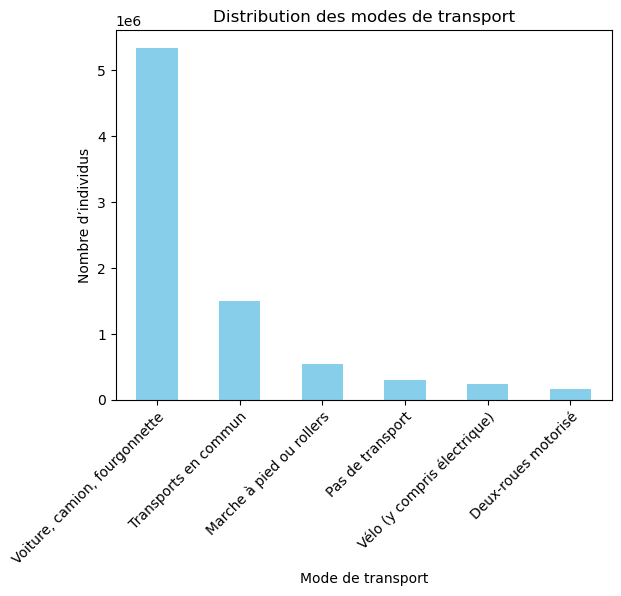

In [3]:
# Distribution des modes de transport utilisés pour aller travailler
transport_distribution = df_mobpro_brut['TRANS_LABEL'].value_counts()
print(transport_distribution)

# Visualisation
transport_distribution.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Distribution des modes de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Nombre d’individus')
plt.show()

TRANS_LABEL
Deux-roues motorisé              38.061997
Marche à pied ou rollers         38.992081
Pas de transport                 44.077751
Transports en commun             37.170818
Voiture, camion, fourgonnette    39.720284
Vélo (y compris électrique)      38.212106
Name: AGEREVQ, dtype: float64


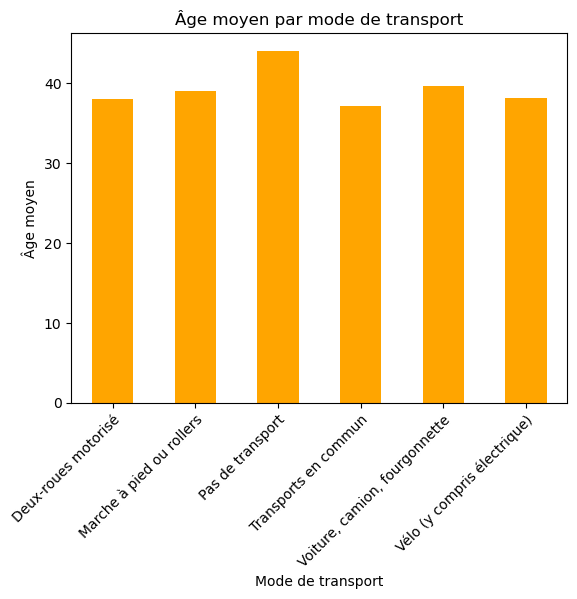

In [4]:
# Âge moyen par mode de transport
age_transport = df_mobpro_brut.groupby('TRANS_LABEL')['AGEREVQ'].mean()
print(age_transport)

# Visualisation
age_transport.plot(kind='bar', color='orange')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Âge moyen par mode de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Âge moyen')
plt.show()


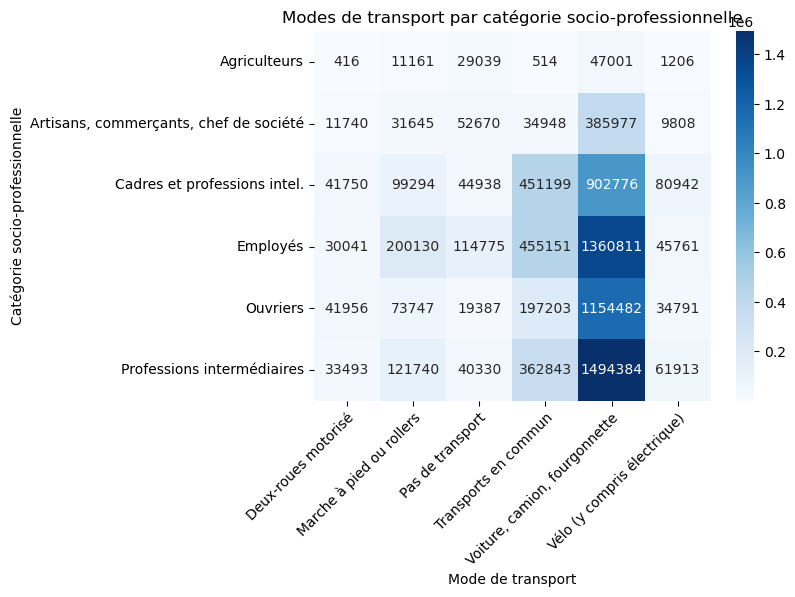

In [5]:
# Distribution des modes de transport par catégorie socio-professionnelle avec labels
cs1_transport = pd.crosstab(df_mobpro_brut['CS_LABEL'], df_mobpro_brut['TRANS_LABEL'])

# Heatmap
sns.heatmap(cs1_transport, annot=True, fmt='d', cmap='Blues')
plt.title('Modes de transport par catégorie socio-professionnelle')
plt.xlabel('Mode de transport')

# Inclinaison des labels avec alignement pour que l'extrémité pointe vers l'axe
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Catégorie socio-professionnelle')
plt.show()


In [6]:
# Création d'une table croisée dynamique pour compter les déplacements
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'])

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)

# En option, si on veut réinitialiser l'index pour avoir COMMUNE en colonne :
# flux_tot = flux_tot.reset_index()

# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)

# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

# Créer les matrices des flux pour chaque groupe
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'])
flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'])
flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'])

# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

# Afficher les dimensions des matrices
print("Dimensions de la matrice (TRANS = 4 ou 5) :", flux_rouge.shape)
print("Dimensions de la matrice (TRANS = 6) :", flux_jaune.shape)
print("Dimensions de la matrice (TRANS = 1, 2 ou 3) :", flux_vert.shape)


Dimensions de la matrice : (34881, 34078)
Dimensions de la matrice (TRANS = 4 ou 5) : (34817, 33012)
Dimensions de la matrice (TRANS = 6) : (17600, 10140)
Dimensions de la matrice (TRANS = 1, 2 ou 3) : (30250, 29908)


In [7]:
flux_rouge

DCLT,01001,01002,01004,01005,01006,01007,01008,01009,01010,01011,...,98735,98736,98738,98753,98758,98807,98811,98815,98818,99999
COMMUNE,,,,,,,,,,,,,,,,,,,,,
01001,7,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01002,0,3,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01004,0,0,585,0,0,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
01005,0,0,0,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01006,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
97421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Convertir la matrice en une matrice éparse (format COO)
sparse_flux = coo_matrix(flux_rouge.values)

# Extraire les indices non nuls et les données
rows = sparse_flux.row  # indices des lignes non nulles
cols = sparse_flux.col  # indices des colonnes non nulles
data = sparse_flux.data  # les valeurs correspondantes (nb_flux)

# Créer le DataFrame avec les codes de villes récupérés depuis l'index et les colonnes de flux_rouge
df_flux_rouge = pd.DataFrame({
    'ville_a': flux_rouge.index[rows],
    'ville_b': flux_rouge.columns[cols],
    'nb_flux': data
})

# Convertir la matrice en une matrice éparse (format COO)
sparse_flux = coo_matrix(flux_vert.values)

# Extraire les indices non nuls et les données
rows = sparse_flux.row  # indices des lignes non nulles
cols = sparse_flux.col  # indices des colonnes non nulles
data = sparse_flux.data  # les valeurs correspondantes (nb_flux)

# Créer le DataFrame avec les codes de villes récupérés depuis l'index et les colonnes de flux_rouge
df_flux_vert = pd.DataFrame({
    'ville_a': flux_vert.index[rows],
    'ville_b': flux_vert.columns[cols],
    'nb_flux': data
})

# Convertir la matrice en une matrice éparse (format COO)
sparse_flux = coo_matrix(flux_jaune.values)

# Extraire les indices non nuls et les données
rows = sparse_flux.row  # indices des lignes non nulles
cols = sparse_flux.col  # indices des colonnes non nulles
data = sparse_flux.data  # les valeurs correspondantes (nb_flux)

# Créer le DataFrame avec les codes de villes récupérés depuis l'index et les colonnes de flux_rouge
df_flux_jaune = pd.DataFrame({
    'ville_a': flux_jaune.index[rows],
    'ville_b': flux_jaune.columns[cols],
    'nb_flux': data
})

In [11]:
assert len(df_flux_rouge) == (flux_rouge != 0).sum().sum()
assert len(df_flux_vert) == (flux_vert != 0).sum().sum()
assert len(df_flux_jaune) == (flux_jaune != 0).sum().sum()

In [12]:
df_flux_jaune

,ville_a,ville_b,nb_flux
0,01001,69382,1
1,01002,92036,1
2,01004,01004,29
3,01004,01027,3
4,01004,01032,3
...,...,...,...
155056,97423,97416,2
155057,97423,97423,8
155058,97424,97414,1
155059,97424,97416,3


In [17]:
contours_comm

,id,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,centroid
0,None,01001,01,84,848241,6563021,L'Abergement-Clémenciat,"POLYGON ((846981.436 6564107.36, 847017.457 65...",POINT (848608.477 6563339.582)
1,None,01002,01,84,887495,6548152,L'Abergement-de-Varey,"POLYGON ((886027.651 6548170.9, 886157.325 654...",POINT (887854.422 6548406.438)
2,None,01004,01,84,882724,6542583,Ambérieu-en-Bugey,"POLYGON ((884889.404 6539629.931, 884795.75 65...",POINT (883688.117 6542884.177)
3,None,01005,01,84,847277,6545791,Ambérieux-en-Dombes,"POLYGON ((845951.25 6547999.078, 846073.72 654...",POINT (847979.005 6545822.006)
4,None,01006,01,84,902191,6519791,Ambléon,"POLYGON ((901336.361 6521123.305, 902460.201 6...",POINT (901674.871 6520029.529)
...,...,...,...,...,...,...,...,...,...
34950,None,97615,976,06,570763,6101694,Pamandzi,"POLYGON ((570365.656 6102429.686, 570416.084 6...",POINT (571959.872 6101926.563)
34951,None,97616,976,06,549586,6095929,Sada,"POLYGON ((551541.346 6096924.233, 551613.387 6...",POINT (551117.28 6094186.47)
34952,None,97617,976,06,549653,6103182,Tsingoni,"POLYGON ((552341.001 6107748.998, 555071.354 6...",POINT (553350.61 6104139.683)
34953,None,16233,16,75,464776,6506602,Mosnac-Saint-Simeux,"POLYGON ((461871.928 6506962.335, 462088.051 6...",POINT (464358.07 6507525.044)


In [18]:
# Pour flux_rouge
df_flux_rouge_merged = pd.merge(
    df_flux_rouge, 
    contours_comm[['codgeo', 'libgeo', 'centroid', 'geometry']], 
    left_on='ville_a', 
    right_on='codgeo', 
    how='left'
)
# Optionnel : supprimer la colonne redondante 'codgeo'
df_flux_rouge_merged.drop(columns=['codgeo'], inplace=True)

# Pour flux_jaune
df_flux_jaune_merged = pd.merge(
    df_flux_jaune, 
    contours_comm[['codgeo', 'libgeo', 'centroid', 'geometry']], 
    left_on='ville_a', 
    right_on='codgeo', 
    how='left'
)
df_flux_jaune_merged.drop(columns=['codgeo'], inplace=True)

# Pour flux_vert
df_flux_vert_merged = pd.merge(
    df_flux_vert, 
    contours_comm[['codgeo', 'libgeo', 'centroid', 'geometry']], 
    left_on='ville_a', 
    right_on='codgeo', 
    how='left'
)
df_flux_vert_merged.drop(columns=['codgeo'], inplace=True)


  ville_a ville_b  nb_flux                   libgeo  \
0   01001   01001        7  L'Abergement-Clémenciat   
1   01001   01004        2  L'Abergement-Clémenciat   
2   01001   01053       10  L'Abergement-Clémenciat   
3   01001   01088        1  L'Abergement-Clémenciat   
4   01001   01093       18  L'Abergement-Clémenciat   

                         centroid  \
0  POINT (848608.477 6563339.582)   
1  POINT (848608.477 6563339.582)   
2  POINT (848608.477 6563339.582)   
3  POINT (848608.477 6563339.582)   
4  POINT (848608.477 6563339.582)   

                                            geometry  
0  POLYGON ((846981.436 6564107.36, 847017.457 65...  
1  POLYGON ((846981.436 6564107.36, 847017.457 65...  
2  POLYGON ((846981.436 6564107.36, 847017.457 65...  
3  POLYGON ((846981.436 6564107.36, 847017.457 65...  
4  POLYGON ((846981.436 6564107.36, 847017.457 65...  
  ville_a ville_b  nb_flux                   libgeo  \
0   01001   69382        1  L'Abergement-Clémenciat   
1   01

In [19]:
df_flux_rouge_merged

,ville_a,ville_b,nb_flux,libgeo,centroid,geometry
0,01001,01001,7,L'Abergement-Clémenciat,POINT (848608.477 6563339.582),"POLYGON ((846981.436 6564107.36, 847017.457 65..."
1,01001,01004,2,L'Abergement-Clémenciat,POINT (848608.477 6563339.582),"POLYGON ((846981.436 6564107.36, 847017.457 65..."
2,01001,01053,10,L'Abergement-Clémenciat,POINT (848608.477 6563339.582),"POLYGON ((846981.436 6564107.36, 847017.457 65..."
3,01001,01088,1,L'Abergement-Clémenciat,POINT (848608.477 6563339.582),"POLYGON ((846981.436 6564107.36, 847017.457 65..."
4,01001,01093,18,L'Abergement-Clémenciat,POINT (848608.477 6563339.582),"POLYGON ((846981.436 6564107.36, 847017.457 65..."
...,...,...,...,...,...,...
884291,97424,97416,11,Cilaos,POINT (460589.982 6096636.474),"POLYGON ((453940.216 6096415.927, 453947.42 60..."
884292,97424,97417,1,Cilaos,POINT (460589.982 6096636.474),"POLYGON ((453940.216 6096415.927, 453947.42 60..."
884293,97424,97418,1,Cilaos,POINT (460589.982 6096636.474),"POLYGON ((453940.216 6096415.927, 453947.42 60..."
884294,97424,97422,2,Cilaos,POINT (460589.982 6096636.474),"POLYGON ((453940.216 6096415.927, 453947.42 60..."
